`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   

# Лабораторная работа №5. Работа с временным рядом

#### Данные отображают цены на акции компании 005930.KS на момент их закрытия.

### Загрузка пакетов

In [2]:
import yfinance as yf

import datetime
from datetime import timedelta
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# оценка качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

from sklearn. model_selection import train_test_split

from concurrent.futures import ThreadPoolExecutor, as_completed

# статистические методы
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# для быстрой обработки пропусков при расчете среднего
from pandas.core.nanops import nanmean as pd_nanmean

# для интерактивного отображения прогресса в расчетах
import tqdm
from tqdm.auto import tqdm
from tqdm import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Загрузка данных

In [3]:
data = yf.Ticker('005930.KS').history(interval = "1d", start
= '2012-01-01')

In [4]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-02 00:00:00+09:00,16911.023365,17069.070312,16831.999891,17069.070312,13151350,0.0,0.0
2012-01-03 00:00:00+09:00,17274.538893,17464.195312,17258.734191,17464.195312,16927750,0.0,0.0
2012-01-04 00:00:00+09:00,17464.187681,17543.211155,16990.046839,17069.070312,17103700,0.0,0.0
2012-01-05 00:00:00+09:00,16958.441606,17053.269798,16673.957031,16673.957031,17298400,0.0,0.0
2012-01-06 00:00:00+09:00,16689.757933,16847.804883,16278.835862,16436.882812,18816250,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00+09:00,64100.000000,65000.000000,63300.000000,64600.000000,14779601,0.0,0.0
2023-04-28 00:00:00+09:00,65200.000000,65900.000000,65000.000000,65500.000000,19699481,0.0,0.0
2023-05-02 00:00:00+09:00,66000.000000,66300.000000,65100.000000,65700.000000,14396948,0.0,0.0


Нам нужны только данные о дате и цене закрытия (столбец 'Close').

In [5]:
data = data[['Close']]

In [6]:
data

,Close
Date,
2012-01-02 00:00:00+09:00,17069.070312
2012-01-03 00:00:00+09:00,17464.195312
2012-01-04 00:00:00+09:00,17069.070312
2012-01-05 00:00:00+09:00,16673.957031
2012-01-06 00:00:00+09:00,16436.882812
...,...
2023-04-27 00:00:00+09:00,64600.000000
2023-04-28 00:00:00+09:00,65500.000000
2023-05-02 00:00:00+09:00,65700.000000


### Построим график временного ряда

<Axes: title={'center': 'Цена на момент закрытия акции'}, xlabel='Date'>

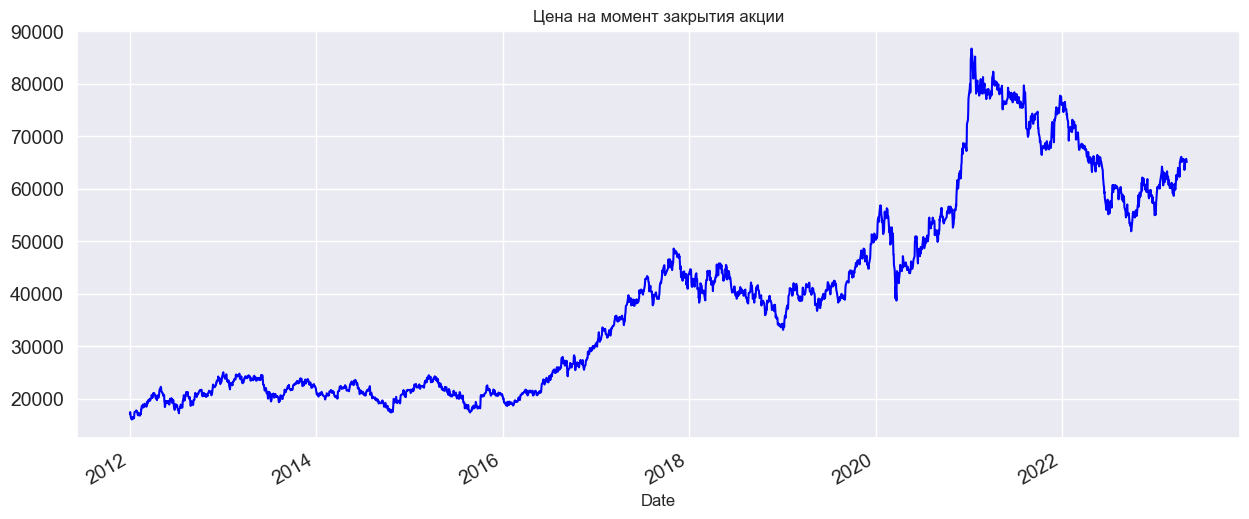

In [7]:
data.Close.plot( figsize=(15,6),title='Цена на момент закрытия акции', fontsize=14, color="blue")

График показывает, что цены на акции 005930.KS были в основном стабильны в начале периода. Однако, существует большое количество короткосрочных колебаний цен, которые не подчиняются общему тренду и вызваны внешними факторами.

На графике цен на момент закрытия акций компании 005930.KS, представленном выше, можно наблюдать общий тренд цен на протяжении всего периода. 

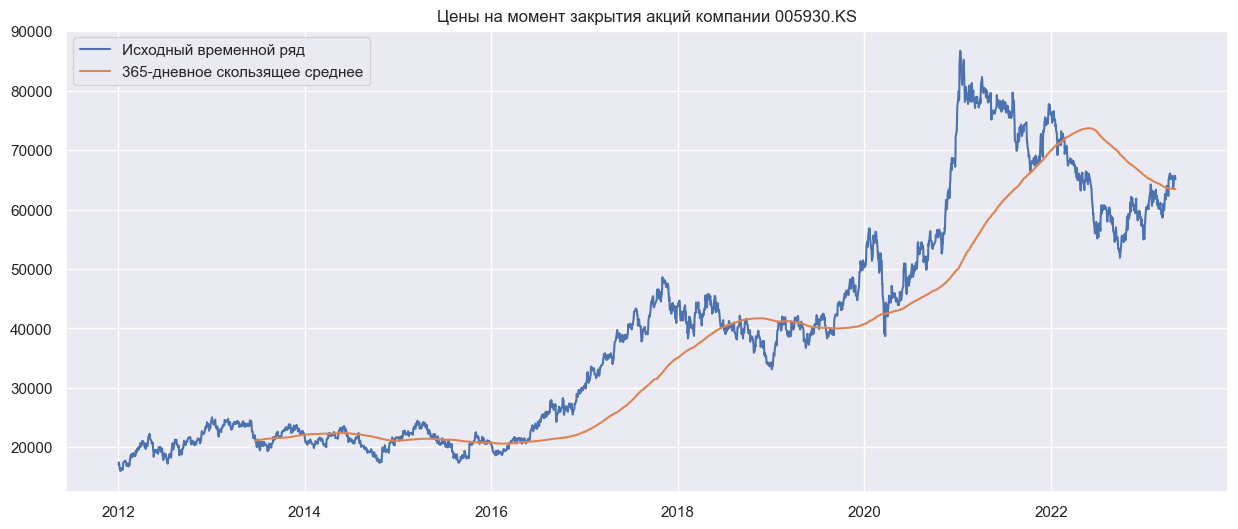

In [8]:
window = 365
rolling_mean = data.Close.rolling(window=window).mean()

plt.figure(figsize=(15,6))
plt.plot(data.Close, label='Исходный временной ряд')
plt.plot(rolling_mean, label='365-дневное скользящее среднее')
plt.legend(loc='best')
plt.title('Цены на момент закрытия акций компании 005930.KS')
plt.show()

### Тест Дикки-Фуллера 

Проверим на уровне значимости 0.05

In [9]:
def test_stationarity(timeseries, window=24, cutoff=0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [10]:
sample_data = data.Close

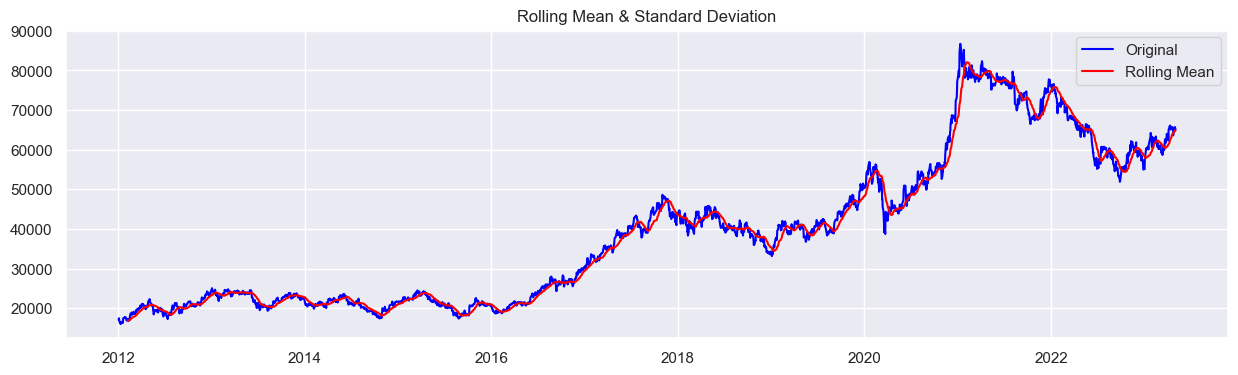

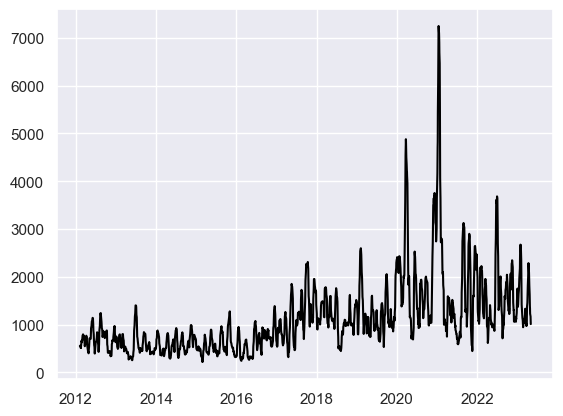

Results of Dickey-Fuller Test:
p-value = 0.8114. The series is likely non-stationary.
Test Statistic                   -0.825767
p-value                           0.811436
#Lags Used                       18.000000
Number of Observations Used    2772.000000
Critical Value (1%)              -3.432711
Critical Value (5%)              -2.862583
Critical Value (10%)             -2.567325
dtype: float64


In [11]:
test_stationarity(sample_data)

На основании теста Dickey-Fuller, можно сделать вывод о том, что временной ряд не является стационарным. Это подтверждается значением p-value, превышающим уровень значимости 0.05, и недостаточным значением тестовой статистики для отклонения от нулевой гипотезы о нестационарности ряда.

### Методология Бокса-Дженкинса.

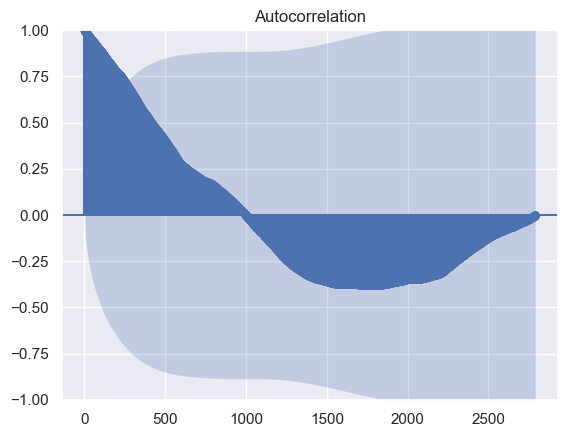

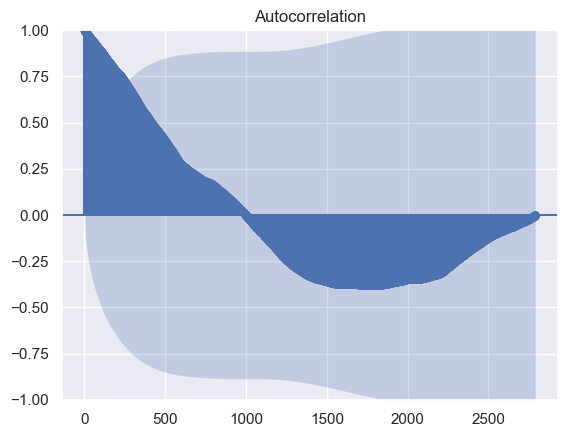

In [12]:
plot_acf(data.Close, lags=2790)

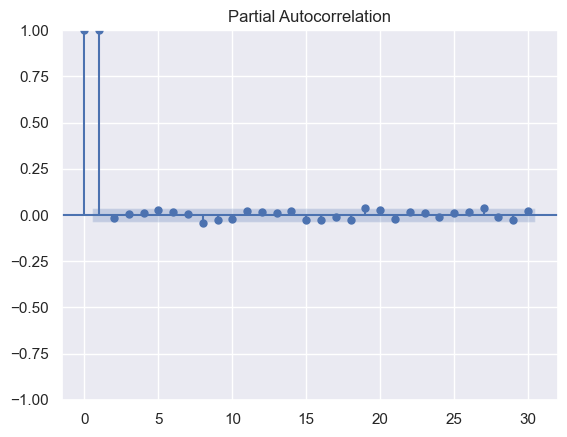

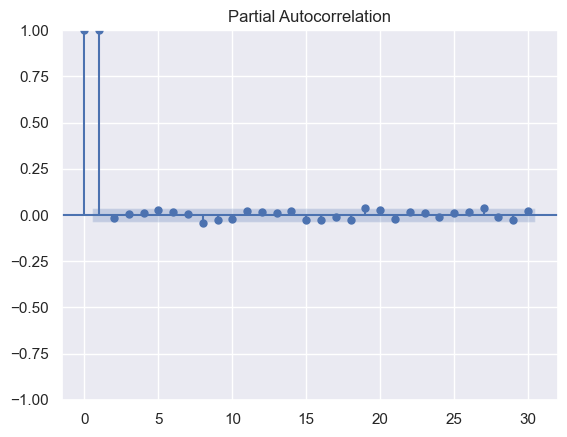

In [13]:
plot_pacf(data.Close, lags=30)

Это означает, что на 250 лаге автокорреляционная функция (ACF) последующие лаги становятся значимыми. Из графика PACF (Partial Autocorrelation Function) можно сделать вывод, что после второго лага все последующие лаги не являются значимыми, т.е. корреляция становится незначительной. 

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели.
Предлагается для начала избавится от трендовой зависимости

### Удаления линейной трендовой составляющей из временного ряда

In [14]:
data["indexs"] = range(1, len(data)+1, 1)
from sklearn.linear_model import LinearRegression

X = np.array(data["indexs"]).reshape((-1, 1))
Y = np.array(data["Close"])

model = LinearRegression().fit(X,Y)
print('Y=', model.coef_[0], '*X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))
data["Close_t"] = data["Close"] - (data["indexs"] * model.coef_[0] + model.intercept_)
data

Y= 20.92979658067296 *X + 9776.02142344325
coefficient of determination: 0.8088086965484658


,Close,indexs,Close_t
Date,,,
2012-01-02 00:00:00+09:00,17069.070312,1,7272.119092
2012-01-03 00:00:00+09:00,17464.195312,2,7646.314296
2012-01-04 00:00:00+09:00,17069.070312,3,7230.259499
2012-01-05 00:00:00+09:00,16673.957031,4,6814.216421
2012-01-06 00:00:00+09:00,16436.882812,5,6556.212406
...,...,...,...
2023-04-27 00:00:00+09:00,64600.000000,2787,-3507.364494
2023-04-28 00:00:00+09:00,65500.000000,2788,-2628.294290
2023-05-02 00:00:00+09:00,65700.000000,2789,-2449.224087


<Axes: title={'center': 'Цены на момент закрытия акций компании 005930.KS без тренда'}, xlabel='Date'>

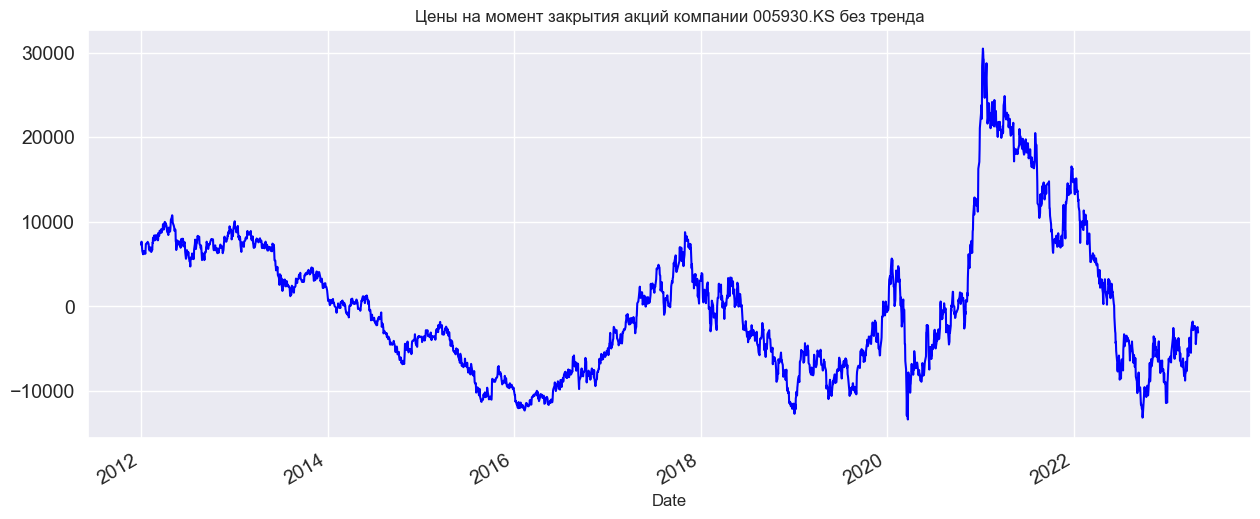

In [15]:
data.Close_t.plot( figsize=(15,6),title='Цены на момент закрытия акций компании 005930.KS без тренда', fontsize=14, color="blue")

### Тест Дикки-Фуллера  без тренда

In [16]:
dftest_t = adfuller(data.Close_t,autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest_t[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest_t[1])

p-value = 0.1627. The series is likely non-stationary.


Хоть ряд и не является стационарным, результаты теста Дики-Фуллера показывают, что значение p-value уменьшилось. Это может свидетельствовать о том, что ряд стал более стационарным, чем раньше. 

### Методология Бокса-Дженкинса без тренда

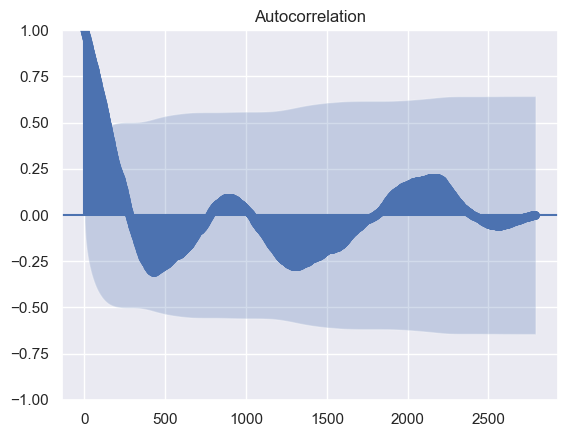

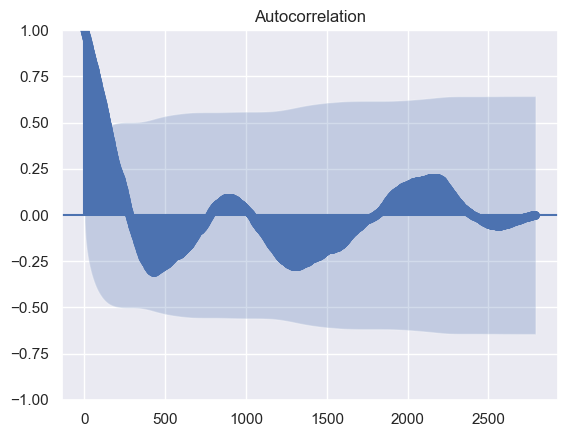

In [17]:
plot_acf(data.Close_t, lags=2790)

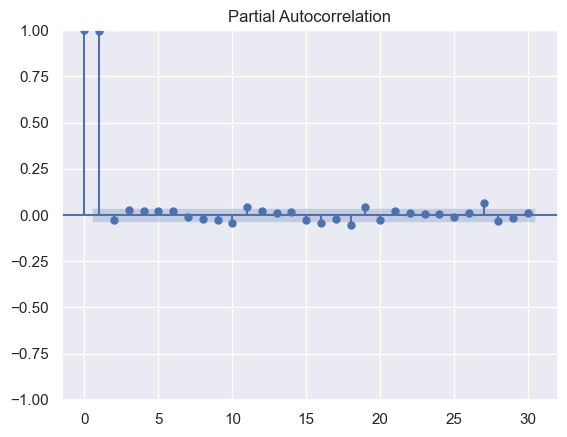

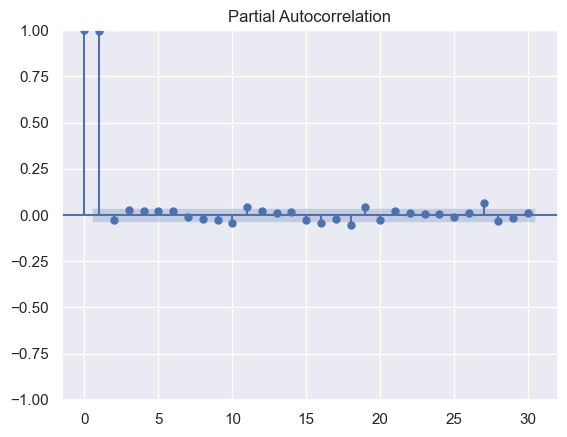

In [18]:
plot_pacf(data.Close_t, lags=30)

Зависимость цены акции от предыдущих значений снизилась, однако она все еще остается существенной.

### Разделяем на обучающую и тестовую выборки

In [19]:
from sklearn. model_selection import train_test_split
# Разделение выборки на обучающую и тестовую
train, test = data[0:2530], data[2530:]

# Проверка размеров выборок
print(f"Размер обучающей выборки: {train.shape[0]}")
print(f"Размер тестовой выборки: {test.shape[0]}")

Размер обучающей выборки: 2530
Размер тестовой выборки: 261


<Axes: title={'center': 'Цена на момент закрытия акции'}, xlabel='Date'>

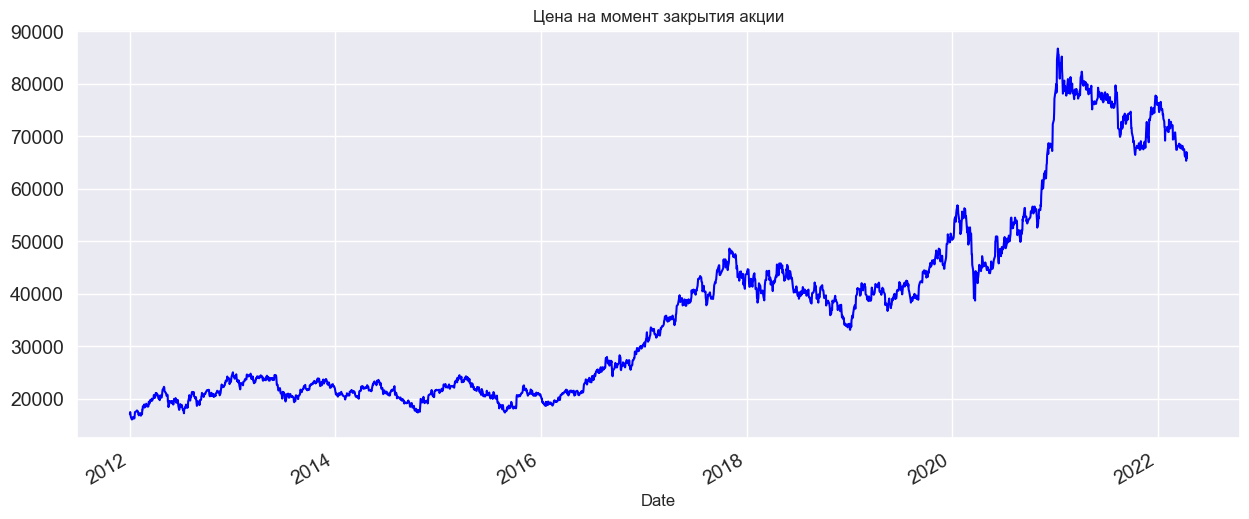

In [20]:
train.Close.plot(figsize=(15,6), title='Цена на момент закрытия акции', fontsize=14, color='blue')

In [21]:
p = range(0, 8)
d = range(0, 3)
q = range(0, 15)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_AIC = np.inf

def find_best_params(params):
    try:
        model_test = sm.tsa.arima.ARIMA(train.Close_t, order=params)
        result_test = model_test.fit()
        return params, result_test.aic
    except Exception:
        return params, np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, aic = future.result()
        if aic < best_AIC:
            best_params = params
            best_AIC = aic

print("Best params:", best_params)
print("Best AIC:", best_AIC)

100%|██████████████████████████████████████████████████████████████████████████████| 360/360 [1:21:13<00:00, 13.54s/it]

Best params: (6, 0, 5)
Best AIC: 26.0


In [22]:
p = range(0, 8)
d = range(0, 3)
q = range(0, 15)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_AIC = np.inf

def find_best_params(params):
    try:
        model_test = sm.tsa.arima.ARIMA(train.Close, order=params)
        result_test = model_test.fit()
        return params, result_test.aic
    except:
        return params, np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, aic = future.result()
        if aic < best_AIC:
            best_params = params
            best_AIC = aic

print("Best params:", best_params)
print("Best AIC:", best_AIC)

100%|██████████████████████████████████████████████████████████████████████████████| 360/360 [1:14:44<00:00, 12.46s/it]

Best params: (4, 1, 4)
Best AIC: 39906.98901630826


Исходя из полученных результатов, можно сделать вывод, что модель ARIMA(6,0,5), которая учитывает тренд, дает более точные прогнозы, чем модель ARIMA(4,1,4) без тренда. Это можно объяснить тем, что в исходных данных присутствует заметный тренд, и учет тренда позволяет лучше описать структуру временного ряда.

### Проверим модель на тестовой выборке

In [23]:
test.Close

Date
2022-04-15 00:00:00+09:00    64958.847656
2022-04-18 00:00:00+09:00    65056.390625
2022-04-19 00:00:00+09:00    65641.601562
2022-04-20 00:00:00+09:00    65739.132812
2022-04-21 00:00:00+09:00    66031.742188
                                 ...     
2023-04-27 00:00:00+09:00    64600.000000
2023-04-28 00:00:00+09:00    65500.000000
2023-05-02 00:00:00+09:00    65700.000000
2023-05-03 00:00:00+09:00    65400.000000
2023-05-04 00:00:00+09:00    65100.000000
Name: Close, Length: 261, dtype: float64

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
model_test = sm.tsa.arima.ARIMA(test.Close, order = (7,2,8))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

print(mean_absolute_percentage_error(test.Close, preds))

2.109911539015015


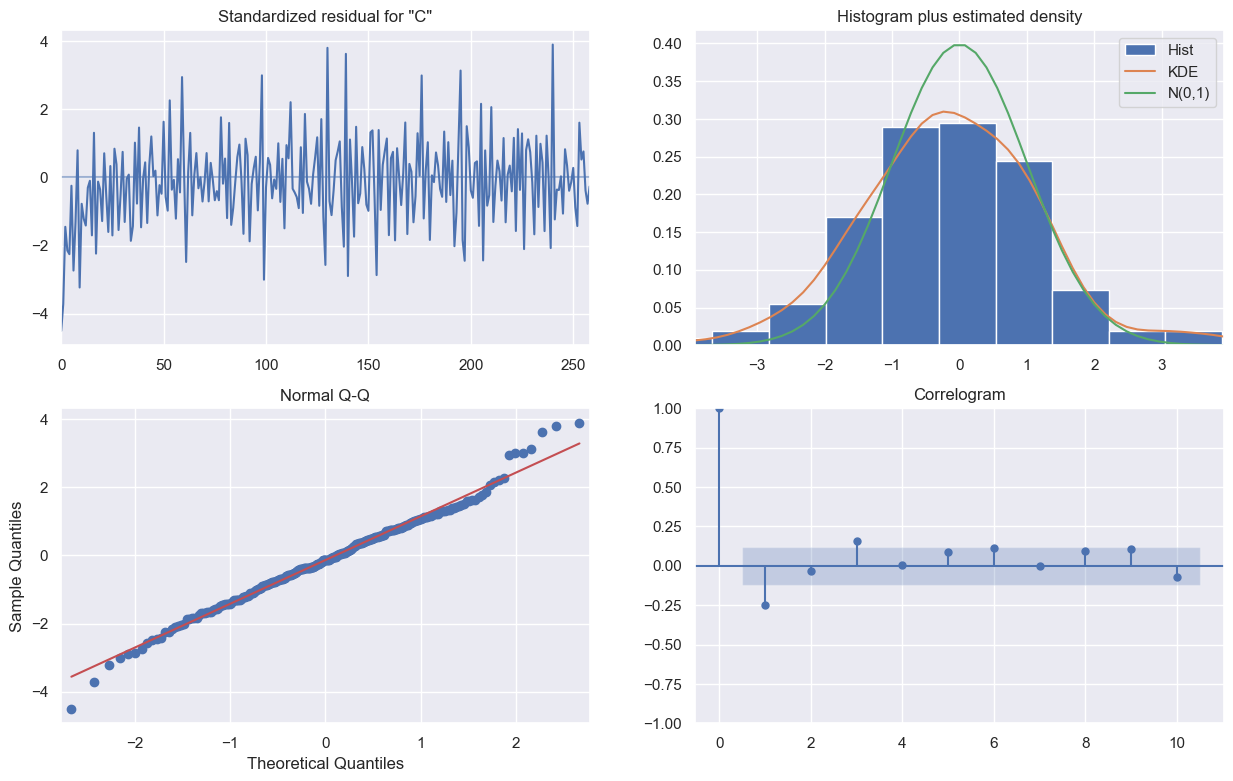

In [26]:
result_test.plot_diagnostics(figsize=(15, 9))
plt.show()

### Построим прогноз

In [27]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

In [28]:
y = pd.Series(test.Close, index=test.index)
y

Date
2022-04-15 00:00:00+09:00    64958.847656
2022-04-18 00:00:00+09:00    65056.390625
2022-04-19 00:00:00+09:00    65641.601562
2022-04-20 00:00:00+09:00    65739.132812
2022-04-21 00:00:00+09:00    66031.742188
                                 ...     
2023-04-27 00:00:00+09:00    64600.000000
2023-04-28 00:00:00+09:00    65500.000000
2023-05-02 00:00:00+09:00    65700.000000
2023-05-03 00:00:00+09:00    65400.000000
2023-05-04 00:00:00+09:00    65100.000000
Name: Close, Length: 261, dtype: float64

In [29]:
dti = pd.date_range("2023-05-04 00:00:00-04:00", periods=10, freq="1D")
dti

DatetimeIndex(['2023-05-04 00:00:00-04:00', '2023-05-05 00:00:00-04:00',
               '2023-05-06 00:00:00-04:00', '2023-05-07 00:00:00-04:00',
               '2023-05-08 00:00:00-04:00', '2023-05-09 00:00:00-04:00',
               '2023-05-10 00:00:00-04:00', '2023-05-11 00:00:00-04:00',
               '2023-05-12 00:00:00-04:00', '2023-05-13 00:00:00-04:00'],
              dtype='datetime64[ns, UTC-04:00]', freq='D')

In [30]:
y_pred_mean = pred_uc.predicted_mean
df = pd.DataFrame(y_pred_mean)
df = df.to_numpy()
print(df[:,0])
y_pred_mean_dti = pd.Series(data=df[:,0],index=dti)
y_pred_mean_dti.index.names = ['Date']
y_pred_mean_dti
type(y_pred_mean_dti)

[65047.80630302 65150.87222852 65079.79955317 64879.40803474
 64571.60749497 64373.23189591 64209.39744979 64201.91974526
 64429.02979583 64612.27009157]


pandas.core.series.Series

In [31]:
y_pred = pred_ci.set_index(dti)
y_pred.index.names = ['Date']
y_pred
type(y_pred)

pandas.core.frame.DataFrame

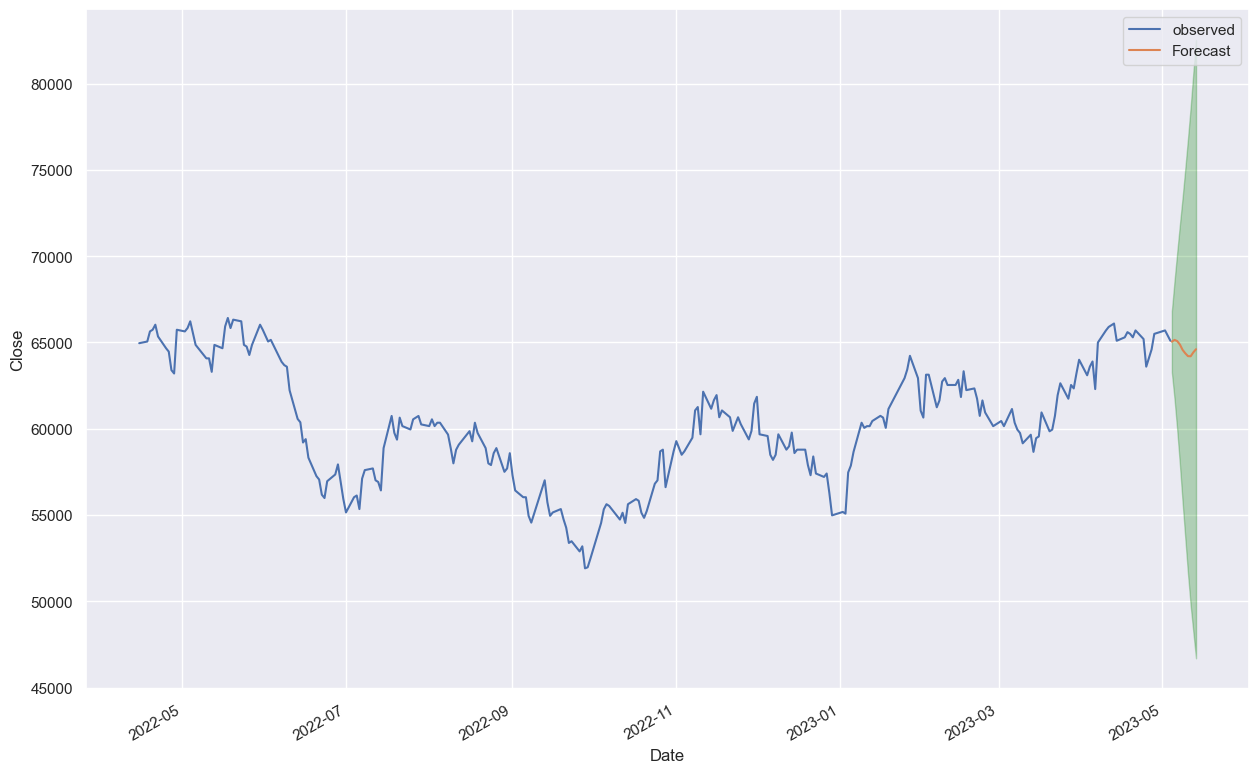

In [32]:
ax = y.plot(label='observed', figsize=(15, 10))
y_pred_mean_dti.plot(ax=ax, label='Forecast')
ax.fill_between(y_pred.index,
y_pred.iloc[:, 0],
y_pred.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()

Исходя из анализа графика, можно сделать вывод, что в будущем цены на акции компании 005930.KS скорее всего сначала снизяться, а потом пойдут вверх.

### Построение моделей для прогноза по разным периодам

In [37]:
data = yf.Ticker('005930.KS').history(interval="1d", start='2012-01-01')
data = data.drop(data.index[-1])
data.shape

(2791, 7)

<Axes: title={'center': 'Цена закрытия акции'}, xlabel='Date'>

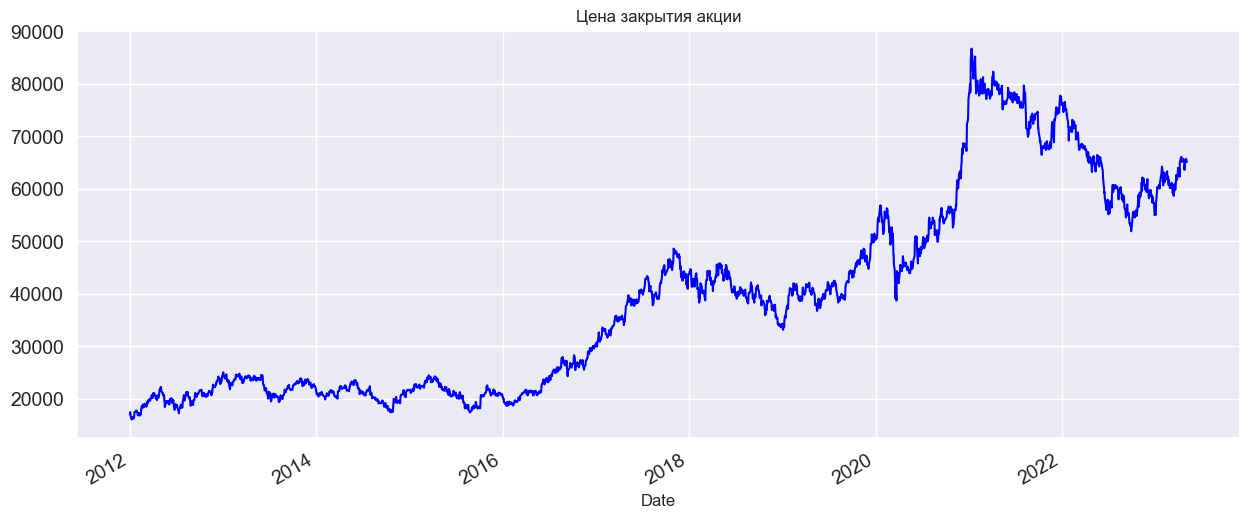

In [38]:
data.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="blue")

### Разделим исходные данные на 3 блока:

1) 2012.01.01 - 2015.10.06

2) 2015.10.06 - 2019.07.25

3) 2019.07.25 - н.в.

In [39]:
data_1 = data.index < '2015-10-06 00:00:00-04:00'
data_1 = data.loc[data_1]
data_1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-02 00:00:00+09:00,16911.029170,17069.076172,16832.005669,17069.076172,13151350,0.0,0.0
2012-01-03 00:00:00+09:00,17274.533097,17464.189453,17258.728401,17464.189453,16927750,0.0,0.0
2012-01-04 00:00:00+09:00,17464.193676,17543.217177,16990.052671,17069.076172,17103700,0.0,0.0
2012-01-05 00:00:00+09:00,16958.443593,17053.271795,16673.958984,16673.958984,17298400,0.0,0.0
2012-01-06 00:00:00+09:00,16689.761899,16847.808887,16278.839731,16436.886719,18816250,0.0,0.0
...,...,...,...,...,...,...,...
2015-09-30 00:00:00+09:00,17941.127921,18495.671875,17778.026758,18495.671875,22946800,0.0,0.0
2015-10-01 00:00:00+09:00,18593.532573,18675.083154,18283.640363,18495.671875,12052050,0.0,0.0
2015-10-02 00:00:00+09:00,18136.842898,18479.355219,18136.842898,18251.013672,13715100,0.0,0.0


In [40]:
data_2 = data.query("index >= '2015-10-06 00:00:00-04:00' & index < '2019-07-25 00:00:00-04:00'")
data_2

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-10-07 00:00:00+09:00,19539.515191,20420.261285,19343.793837,20403.951172,39975100,0.0,0.0
2015-10-08 00:00:00+09:00,20387.639564,20860.632802,20387.639564,20713.841797,28533850,0.0,0.0
2015-10-12 00:00:00+09:00,20550.736328,20599.666653,20338.704922,20550.736328,18948700,0.0,0.0
2015-10-13 00:00:00+09:00,20550.740659,20746.461998,20355.019319,20420.259766,9900000,0.0,0.0
2015-10-14 00:00:00+09:00,20355.022129,20550.743496,20175.610876,20452.882812,8752550,0.0,0.0
...,...,...,...,...,...,...,...
2019-07-19 00:00:00+09:00,41922.692533,42192.291842,41877.759315,42057.492188,8819393,0.0,0.0
2019-07-22 00:00:00+09:00,42057.495167,42506.827380,41877.762282,42416.960938,9009109,0.0,0.0
2019-07-23 00:00:00+09:00,42551.765257,42731.498162,42282.165900,42506.832031,9061381,0.0,0.0


In [41]:
data_3 = data.query("index > '2019-07-25 00:00:00-04:00'")
data_3

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-26 00:00:00+09:00,41922.691270,42372.023438,41832.824836,42372.023438,7873886,0.0,0.0
2019-07-29 00:00:00+09:00,42057.498746,42282.164872,41338.567143,41428.433594,6856846,0.0,0.0
2019-07-30 00:00:00+09:00,41608.162023,42102.427447,41608.162023,41832.828125,5551014,0.0,0.0
2019-07-31 00:00:00+09:00,41518.298391,41877.764178,40439.901030,40754.433594,12872916,0.0,0.0
2019-08-01 00:00:00+09:00,40350.029599,40889.228213,40305.096382,40619.628906,7811181,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00+09:00,64100.000000,65000.000000,63300.000000,64600.000000,14779601,0.0,0.0
2023-04-28 00:00:00+09:00,65200.000000,65900.000000,65000.000000,65500.000000,19699481,0.0,0.0
2023-05-02 00:00:00+09:00,66000.000000,66300.000000,65100.000000,65700.000000,14396948,0.0,0.0


### Разделим выборку на тестовую и обучающую

In [42]:
train_1, test_1 = data_1[0:835], data_1[835:]
train_2, test_2 = data_2[0:835], data_2[835:]
train_3, test_3 = data_3[0:835], data_3[835:]

In [53]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_aic = np.inf

def find_best_params(params):
    try:
        model = sm.tsa.arima.ARIMA(train_1.Close, order=params)
        result = model.fit()
        return params, result.aic
    except:
        return params, np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, aic = future.result()
        if aic < best_aic:
            best_params = params
            best_aic = aic

model = sm.tsa.arima.ARIMA(test_1.Close, order=best_params)
result = model.fit()

print("Best params:", best_params)
print("AIC on train:", best_aic)
print("AIC on test:", result.aic)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [14:46<00:00,  3.55s/it]


Best params: (1, 4, 4)
AIC on train: 1390.7741952281558
AIC on test: 1420.920983718825


In [43]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_aic = np.inf

def find_best_params(params):
    try:
        model = sm.tsa.arima.ARIMA(train_2.Close, order=params)
        result = model.fit()
        return params, result.aic
    except:
        return params, np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, aic = future.result()
        if aic < best_aic:
            best_params = params
            best_aic = aic

model = sm.tsa.arima.ARIMA(test_2.Close, order=best_params)
result = model.fit()

print("Best params:", best_params)
print("AIC on train:", best_aic)
print("AIC on test:", result.aic)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [17:30<00:00,  4.20s/it]


Best params: (2, 3, 2)
AIC on train: 10.0
AIC on test: 1517.6758895682378


In [44]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_aic = np.inf

def find_best_params(params):
    try:
        model = sm.tsa.arima.ARIMA(train_3.Close, order=params)
        result = model.fit()
        return params, result.aic
    except:
        return params, np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, aic = future.result()
        if aic < best_aic:
            best_params = params
            best_aic = aic

model = sm.tsa.arima.ARIMA(test_3.Close, order=best_params)
result = model.fit()

print("Best params:", best_params)
print("AIC on train:", best_aic)
print("AIC on test:", result.aic)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [15:18<00:00,  3.67s/it]

Best params: (0, 1, 0)
AIC on train: 13834.178252178583
AIC on test: 1561.893594362559


Из результатов моделирования видно, что лучшая модель на первом блоке данных имеет порядок (1,4,4) и достигает AIC на тренировочной выборке в размере 1390.77, а на тестовой - 1420.92. Лучшая модель на втором блоке данных имеет порядок (2,3,2) и достигает AIC на тренировочной выборке в размере 10.0, а на тестовой - 1517.68. Лучшая модель на третьем блоке данных имеет порядок (0,1,0) и достигает AIC на тренировочной выборке в размере 13834.18, а на тестовой - 1561.89.

Модель с наименьшим значением AIC на тестовой выборке является наиболее предпочтительной для прогнозирования будущих значений. Следовательно, на основе результатов моделирования можно сделать вывод, что наиболее точная модель на тестовой выборке была построена на первом блоке данных и имеет порядок (1,4,4).